<a href="https://colab.research.google.com/github/kdmid/Class_Python/blob/main/Kaggle/Cassava_Leaf_Disease_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. 데이터 세팅

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = 'My Drive/Class_Python/Kaggle/Cassava_Leaf_Disease_Classification/data/cassava-leaf-disease-classification'

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
print(PROJECT_PATH)

/content/drive/My Drive/Class_Python/Kaggle/Cassava_Leaf_Disease_Classification/data/cassava-leaf-disease-classification


마지막으로 데이터가 있는 폴더로 이동합니다.

In [ ]:
%cd "{PROJECT_PATH}"

/content/drive/My Drive/Class_Python/Kaggle/Cassava_Leaf_Disease_Classification/data/cassava-leaf-disease-classification


# II. TF/Keras를 이용한 Cassava 질병분류용 EfficientNet+Augmentation(효율적인 Net 증가)

- 데이터를 로드하고, 고급 데이터 증강을 적용하고, EfficientNet을 교육하고, 모델을 사용하여 테스트 이미지를 예측하는 완전한 파이프라인을 만들고자 한다.

- 교육용 80%, 검증용 20%의 분할만으로 한 접이식만 제공한다.

- 원본 이미지 크기 때문에, 가능한 최고 화질 유지를 위해 원본 이미지에서 300x300 이미지를 무작위로 자르겠다.

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

In [ ]:
import time
import datetime

In [ ]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.41.1
tensorflow==2.3.1
seaborn==0.11.0
scikit-learn==0.22.2.post1
Pillow==7.0.0
pandas==1.1.4
numpy==1.18.5
matplotlib==3.2.2
imgaug==0.4.0
google==2.0.3


- tqdm==4.45.0
- tensorflow==2.3.1
- seaborn==0.10.0
- scikit-learn==0.23.2
- Pillow==8.0.1
- pandas==1.1.4
- numpy==1.18.5
- matplotlib==3.2.1
- imgaug==0.4.0

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 55kB/s 


In [ ]:
!pip uninstall numpy

Uninstalling numpy-1.18.5:
  Would remove:
    /usr/bin/f2py
    /usr/bin/f2py3
    /usr/bin/f2py3.6
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.6
    /usr/local/lib/python3.6/dist-packages/numpy-1.18.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/numpy.libs/libgfortran-ed201abd.so.3.0.0
    /usr/local/lib/python3.6/dist-packages/numpy.libs/libopenblasp-r0-34a18dc3.3.7.so
    /usr/local/lib/python3.6/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.18.5


In [ ]:
!pip install numpy==1.18.5

     |████████████████████████████████| 20.1MB 1.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip uninstall imgaug

Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.6/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9


In [ ]:
!pip install imgaug==0.4.0

     |████████████████████████████████| 952kB 8.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


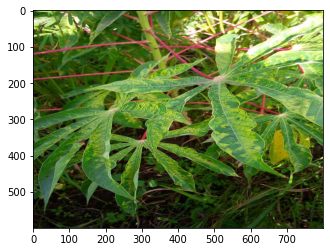

In [ ]:
img = Image.open("./train_images/3412658650.jpg")
plt.imshow(img)
plt.show()

## 01 학습용, 확인용 데이터 generators 준비하기

In [ ]:
training_folder = './train_images/'

In [ ]:
samples_df = pd.read_csv("train.csv")
samples_df = shuffle(samples_df, random_state=42)
samples_df["label"] = samples_df["label"].astype("str")
samples_df.head()

,image_id,label
9134,2615227158.jpg,4
1580,1277648239.jpg,3
7304,2305895487.jpg,3
13196,336299725.jpg,2
5333,1951270318.jpg,2


- 80%의 데이터는 학습용, 나머지 20%는 확인(검증)용 으로 사용하겠다.

In [ ]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

- 아래 코드는 training set를 거치며, 모델에 공급되는 모든 미래 이미지의 표준화 적용을 위해 각 밴드의 평균과 표준편차를 추출할 것이다.

In [ ]:
red_mean = []
green_mean = []
blue_mean = []

red_std = []
green_std = []
blue_std = []

with tqdm(total=len(training_df)) as pbar:
    for idx, row in training_df.iterrows():
        pbar.update(1)
        img = np.array(Image.open(training_folder+row.image_id))
        red_mean.append(np.mean(img[:,:,0]))
        green_mean.append(np.mean(img[:,:,1]))
        blue_mean.append(np.mean(img[:,:,2]))
        red_std.append(np.std(img[:,:,0]))
        green_std.append(np.std(img[:,:,1]))
        blue_std.append(np.std(img[:,:,2]))

dataset_mean_rgb = [np.mean(red_mean), np.mean(green_mean), np.mean(blue_mean)]
dataset_std_rgb = [np.mean(red_std), np.mean(green_std), np.mean(blue_std)]

print(dataset_mean_rgb)
print(dataset_std_rgb)

100%|██████████| 17117/17117 [1:37:46<00:00,  2.92it/s]

[109.68583152993612, 126.69483978793012, 79.86038044707017]
[56.00068876150312, 57.16459853546657, 51.34657775629341]


In [ ]:
def get_cropped_image(img_path, crop_size=300):
    '''
    Randomly select a 300x300 pixel area from the full image
    '''
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)

    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)

    cropped_img = img[x:x+crop_size , y:y+crop_size,:]
    
    return cropped_img

def standardise_channel(channel, mean, std):
    return np.array((channel-mean)/std)

def standardise_image(image, dataset_mean, dataset_std):
    standardised_image = np.transpose(np.array([standardise_channel(image[:,:,0], dataset_mean[0], dataset_std[0]),
                                               standardise_channel(image[:,:,1], dataset_mean[1], dataset_std[1]), 
                                               standardise_channel(image[:,:,2], dataset_mean[2], dataset_std[2])]),
                                     (1,2,0))
    return standardised_image

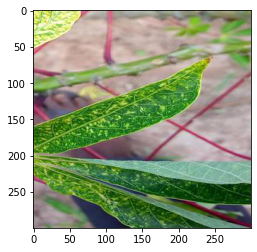

In [ ]:
cropped_img = get_cropped_image("./train_images/1951270318.jpg")
plt.imshow(cropped_img)
plt.show()

- training data에 사요할 증가(확대. augmentation) 방법 세트를 준비해왔다.
- traditional image flip, gaussian blur, contrast, brightness, scale, grayscale, cutout, dropout

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.5, 1.5)),
    iaa.Affine(scale={"x": (1, 1.2), "y":(1, 1.2)}),
    iaa.Sometimes(0.4,
                 iaa.GaussianBlur(sigma=(0,2))),
    iaa.Sometimes(0.3,
                 iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.3,
                 iaa.SigmoidContrast(gain=(3, 6), cutoff=(0.4, 0.6))),
    iaa.Sometimes(0.5,
                 iaa.Dropout(p=(0, 0.2))),
    iaa.Cutout(nb_iterations=(1, 4), size=(0.05,0.4), squared=False, fill_mode="gaussian", fill_per_channel=True),
])

- 위에서 정의한 증가(augmentation)는 아래코드를 사용하여 시각화한다.

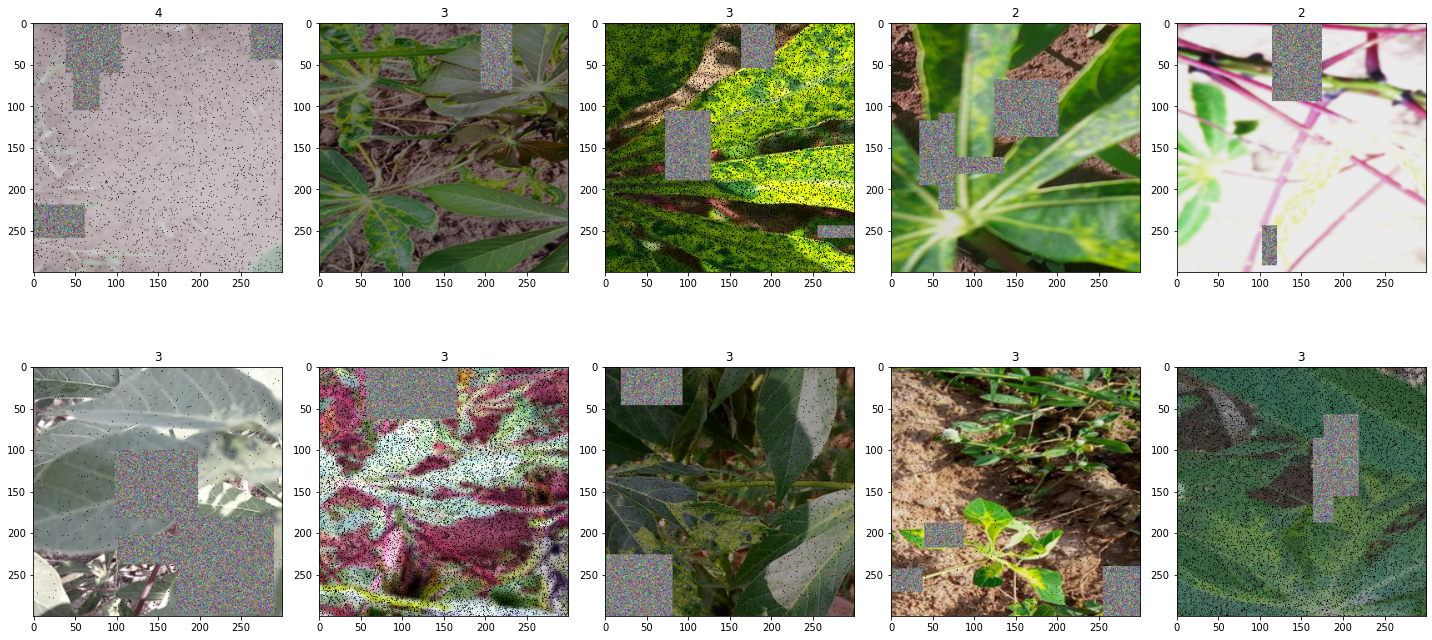

In [ ]:
images = [get_cropped_image(training_folder+image_filename) for image_filename in samples_df[:10].image_id.values]
labels = samples_df[:10].label.values
augmented_images = augmentation.augment_images(images=images)

sample_number = len(augmented_images)
fig = plt.figure(figsize = (20,sample_number))
for i in range(0,sample_number):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(augmented_images[i])
    ax.set_title(str(labels[i]))
plt.tight_layout()
plt.show()

- Keras의 구현에 있어서 RandomCrop function을 재현하기 위해 이 사용자 발생기를 구현한다.

In [ ]:
def custom_generator(image_path_list, groundtruth_list, folder, batch_size=16, training_mode=True):
    
    while True:
        for start in range(0, len(image_path_list), batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)
            
            image_list = [get_cropped_image(folder+"/"+image_path) for image_path in image_path_list[start:end]]
            
            #only apply augmentation during training
            if training_mode:
                image_list = augmentation.augment_images(images=image_list)

            #standardise the images
            image_list = [standardise_image(image, dataset_mean_rgb, dataset_std_rgb) for image in image_list]
            
            X_batch = np.array(image_list)
            Y_batch = tf.keras.utils.to_categorical(np.array(groundtruth_list[start:end]),5) 

            yield X_batch, Y_batch

## 02 Build the model
- EfficientNetB3를 사용하는데 이 위에 5가지 질병 class를 예측하기 위해 몇 개의 output layer를 추가한다.
- EfficientNetB3는 처음에 이러한 유형의 입력에 대해 설계되었기 때문에 모든 이미지는 300x300 픽셀이다

In [ ]:
batch_size = 32
image_size = 300
input_shape = (image_size, image_size, 3)
classes_to_predict = sorted(training_df.label.unique())
effnet_layers = EfficientNetB3(weights=None, include_top=False, input_shape=input_shape)
effnet_layers.load_weights("efficientnetb_notop/efficientnetb3_notop.h5")

for layer in effnet_layers.layers:
    layer.trainable = True

dropout_dense_layer = 0.3

model = Sequential()
model.add(effnet_layers)
    
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(len(classes_to_predict), activation="softmax"))
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam()) # learning_rate=1e-4

In [ ]:
class_weights = class_weight.compute_class_weight("balanced", classes_to_predict, training_df.label.values)
class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes_to_predict)}

In [ ]:
start = time.time()

history = model.fit_generator(custom_generator(training_df["image_id"], training_df["label"], training_folder, batch_size=batch_size, training_mode=True),
                  steps_per_epoch = int(len(training_df)/batch_size),
                  epochs = 2, 
                  validation_data=custom_generator(validation_df["image_id"], validation_df["label"], training_folder, batch_size=batch_size),
                  validation_steps=int(len(validation_df)/batch_size),
                  class_weight=class_weights_dict,
                  callbacks=callbacks)


sec = time.time() - start
times = str(datetime.timedelta(seconds = sec)).split(".")
times = times[0]
print(times)

Epoch 1/2
534/534 [==============================] - ETA: 0s - loss: 1.5007

## 03 Verification of the training process

- 우리는 training과 validation 모두에서 비슷한 수준으로 작동하는지 확인할 것이다.
- training 곡선은 training을 너무 일찍 중단했는지 또는 검증 데이터와 비교했을 때 과충분한지 알려준다.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

- 훈련 단계부터 유지한 최고의 무게를 load한다.
- 모델이 어떻게 작동하는지 확인하기 위해 확인용 set에 대해 예측을 시도할 것이다.
- 이는 계속해서 잘못 분류되는 모든 클래스를 강조하는데 도움을 줄 수 있다.

In [ ]:
model.load_weights("best_model.h5")

## 04 Prediction on test images

In [ ]:
def scan_over_image(img_path, crop_size=300):
    '''
    Will extract 300x300 images covering the whole original image
    with some overlap between images
    '''
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)

    x_img_origins = [0,75,150,225,300]
    y_img_origins = [0,125,250,375,500]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return img_list

In [ ]:
def display_samples(img_path):
    '''
    Display all 300x300 images extracted from original images
    '''
    
    img_list = scan_over_image(img_path)
    sample_number = len(img_list)
    fig = plt.figure(figsize = (25,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(5, 5, i+1)
        ax.imshow(img_list[i])
        ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

display_samples("./train_images/3412658650.jpg")

- 이전 버전의 모델은 너무 많은 식물을 건강한 것으로 잘못 분류하는 것 같다.
- 만약 질병이 초기 단계에 있다면, 그것은 식물의 작은 부분에만 영향을 미칠 것이다. 따라서 이미지에 대해 가장 예측 가능한 진단을 취하는 대신 임계값을 설정했고, 화초는 이미지의 70%(25개 중 17개 영역)가 이와 같이 분류될 경우에만 "건강"으로 간주될 것이다.

In [ ]:
def predict_and_vote(image_filename, folder):
    '''
    Run the model over 25 local areas of the given image,
    before making a decision depending on the most predicted
    disease.
    '''
    local_image_list = scan_over_image(folder+image_filename)
    local_image_list = [standardise_image(image, dataset_mean_rgb, dataset_std_rgb) for image in local_image_list]
    predictions = model.predict(np.array(local_image_list))
    prediction_list = [np.argmax(pred) for pred in predictions]
    
    #percentage of healthy areas to call a plant healthy
    healthy_threshold=0.7
    if prediction_list.count(4)>int(len(prediction_list)*healthy_threshold):
        final_prediction = 4
    else:
        #keep the predictions regarding diseases and keep the highest sum overall
        final_prediction = int(np.argmax(np.sum(predictions[:,:4], axis=0)))
    return final_prediction

In [ ]:
def run_predictions_over_image_list(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder))
    return predictions

- 우리는 test set에 대한 가시성이 거의 없기 때문에 나는 먼저 validation set의 예측 파이프라인에 대한 모든 기능을 시험한다.

In [ ]:
validation_df["results"] = run_predictions_over_image_list(validation_df["image_id"], training_folder)

In [ ]:
!cat ../input/cassava-leaf-disease-classification/label_num_to_disease_map.json

In [ ]:
validation_df[:20]

In [ ]:
true_positives = 0
prediction_distribution_per_class = {"0":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "1":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "2":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "3":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "4":{"0": 0, "1": 0, "2":0, "3":0, "4":0}}
number_of_images = len(validation_df)
for idx, pred in validation_df.iterrows():
    if int(pred["label"]) == pred.results:
        true_positives+=1
    prediction_distribution_per_class[pred["label"]][str(pred.results)] += 1
print("accuracy: {}%".format(true_positives/number_of_images*100))

In [ ]:
prediction_distribution_per_class

- 우리는 또한 결과로부터 heatmap을 그려서 이 새로운 모델이 질병을 잘못 분류하는 곳을 더 잘 이해할 수 있다.
- heatmap에서 각 행은 데이터 집합의 균형이 맞지 않는다는 사실에 개의치 않고 질병별 분류 분포를 강조하기 위해 정규화된다.

In [ ]:
heatmap_df = pd.DataFrame(columns={"groundtruth","prediction","value"})
for key in prediction_distribution_per_class.keys():
    for pred_key in prediction_distribution_per_class[key].keys():
        value = prediction_distribution_per_class[key][pred_key]/validation_df.query("label==@key").count()[0]
        heatmap_df = heatmap_df.append({"groundtruth":key,"prediction":pred_key,"value":value}, ignore_index=True)   

heatmap = heatmap_df.pivot(index='groundtruth', columns='prediction', values='value')
sns.heatmap(heatmap,cmap="Blues")

In [ ]:
test_folder = './test_images/'
submission_df = pd.DataFrame(columns={"image_id","label"})
submission_df["image_id"] =  os.listdir(test_folder)
submission_df["label"] = 0

In [ ]:
submission_df["label"] = run_predictions_over_image_list(submission_df["image_id"], test_folder)

In [ ]:
submission_df

In [ ]:
submission_df.to_csv("submission.csv", index=False)